# Week 29

## Ensuring Symmetry in Subgraph Comparison

In the previous version, we used the flattened adjacency matrix as a hash to identify and count enclosing subgraphs. However, this method is sensitive to node ordering - structurally identical subgraphs (i.e., isomorphic) could be misclassified as distinct if the node indices were permuted.

### Upgrade: Canonical Graph Hashing with Weisfeiler-Lehman

To address this, we now apply the WL graph hashing algorithm via NetworkX, this ensures that:

- Isomorphic subgraphs produce the same hash, regardless of how their nodes are ordered in the matrix.
- We correctly group structurally equivalent motifs even across different parts of the food web or different food webs.
- The top-k most frequent enclosing subgraphs now reflect actual motif recurrence, not artifacts of node ordering.

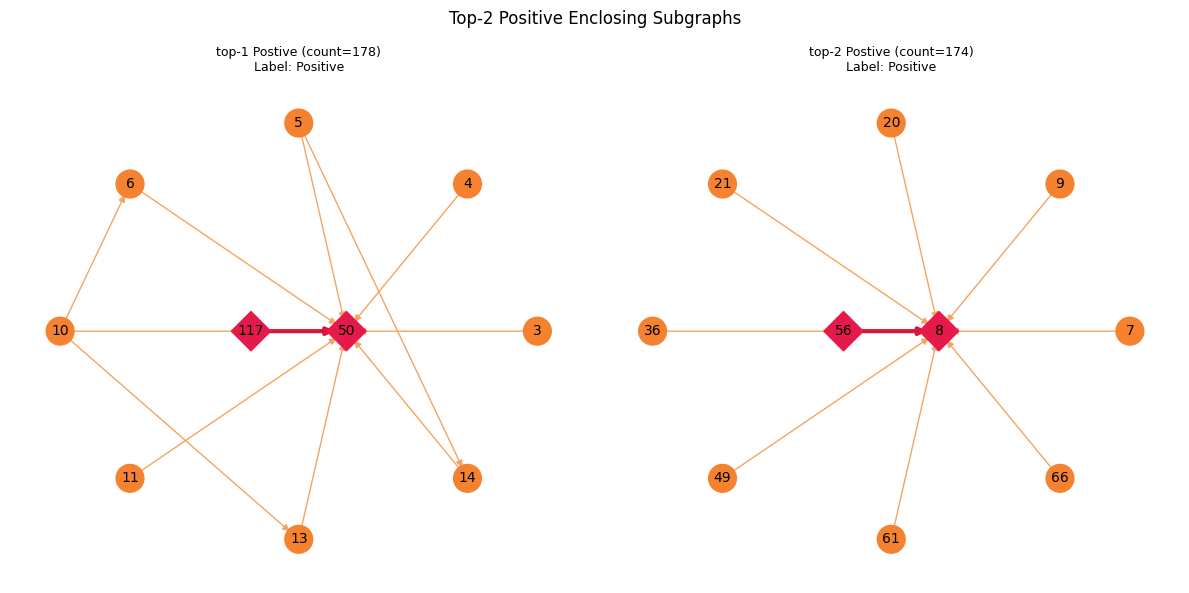

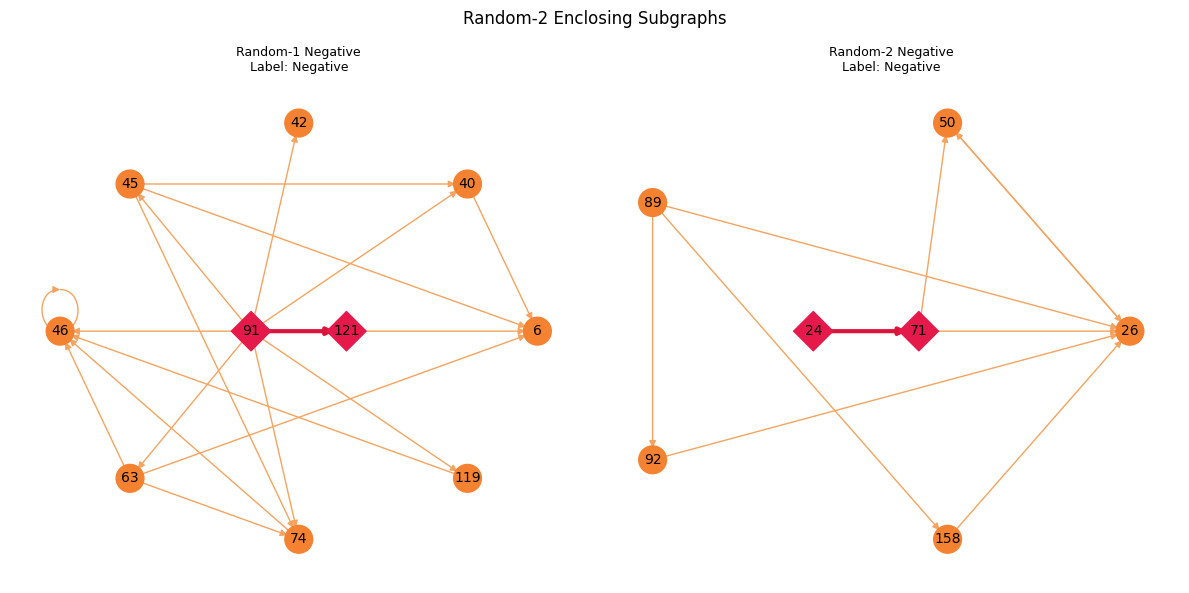

In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.sparse import issparse
from collections import Counter
from math import pi, cos, sin
from networkx.algorithms.isomorphism import DiGraphMatcher

def canonical_hash(adj_matrix):
    G = nx.DiGraph(adj_matrix)
    return nx.weisfeiler_lehman_graph_hash(G, node_attr=None, edge_attr=None)

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

def centered_layout(G, link, radius=2.5):
    source, target = link
    pos = {
        source: np.array([-0.5, 0.0]),
        target: np.array([0.5, 0.0])
    }
    remaining = [n for n in G.nodes() if n not in link]
    n = len(remaining)
    if n == 0:
        return pos
    angles = np.linspace(0, 2 * pi, n, endpoint=False)
    for i, node in enumerate(remaining):
        pos[node] = np.array([radius * cos(angles[i]), radius * sin(angles[i])])
    return pos

def draw_graph_on_ax(adj, nodes, link, label, title, ax):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if adj[i, j] != 0:
                G.add_edge(u, v)
    pos = centered_layout(G, link)
    highlighted_nodes = {link[0], link[1]}
    node_color = ['#e6194b' if n in highlighted_nodes else '#f58231' for n in G.nodes()]
    node_shapes = ['D' if n in highlighted_nodes else 'o' for n in G.nodes()]

    for shape in set(node_shapes):
        nodelist = [n for n, s in zip(G.nodes(), node_shapes) if s == shape]
        colorlist = [node_color[list(G.nodes()).index(n)] for n in nodelist]
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=colorlist, node_shape=shape, node_size=400, ax=ax)
    
    normal_edges = [e for e in G.edges() if e != link]
    nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color='sandybrown', arrows=True, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[link], edge_color='crimson', width=3, arrows=True, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

    ax.set_title(f"{title}\nLabel: {'Positive' if label == 1 else 'Negative'}", fontsize=9)
    ax.axis('off')

def plot_graphs(subgraphs, titles, suptitle):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for i, (adj, nodes, link, label) in enumerate(subgraphs):
        draw_graph_on_ax(adj, nodes, link, label, titles[i], axes[i])
    plt.suptitle(suptitle, fontsize=12)
    plt.tight_layout()
    plt.show()

folder_path = "../../src/matlab/data/result_building_blocks/building_blocks/Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1_tax_mass"
math_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mat")]

positive_counter = Counter()
positive_subgraphs = {}
negative_subgraphs = []

for path in math_paths:
    mat = scipy.io.loadmat(path)
    if 'ordered_adj' not in mat or 'label' not in mat or 'link' not in mat or 'nodes' not in mat:
        continue

    ordered_adj = sanitize_matrix(mat['ordered_adj'])
    adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
    nodes = [int(x) for x in mat['nodes'].flatten()]
    label = int(mat['label'][0][0])
    link = tuple(int(x) for x in mat['link'].flatten())

    if link[0] not in nodes or link[1] not in nodes:
        continue

    # flat_hash = np.nan_to_num(ordered_adj.flatten(), nan=0.0, posinf=0.0, neginf=0.0).astype(int)
    # hash_key = tuple(flat_hash)
    hash_key = canonical_hash(ordered_adj)

    if label == 1:
        positive_counter[hash_key] += 1
        if hash_key not in positive_subgraphs:
            positive_subgraphs[hash_key] = (adj_before, nodes, link, label)
    else:
        negative_subgraphs.append((adj_before, nodes, link, label))

# Top 2 postive subgraphs
most_common_positives = positive_counter.most_common(2)
positive_to_plot = []
positive_titles = []

for i, (hash_key, count) in enumerate(most_common_positives, 1):
    data = positive_subgraphs[hash_key]
    positive_to_plot.append(data)
    positive_titles.append(f"top-{i} Postive (count={count})")

# 2 random negative subgraphs
random_negatives = random.sample(negative_subgraphs, min(2, len(negative_subgraphs)))
negative_titles = [f"Random-{i+1} Negative" for i in range(len(random_negatives))]

# Plot figures
plot_graphs(positive_to_plot, positive_titles, "Top-2 Positive Enclosing Subgraphs")
plot_graphs(random_negatives, negative_titles, "Random-2 Enclosing Subgraphs")

Processing folder: ../../src/matlab/data/result_building_blocks/building_blocks/AEW01_tax_mass


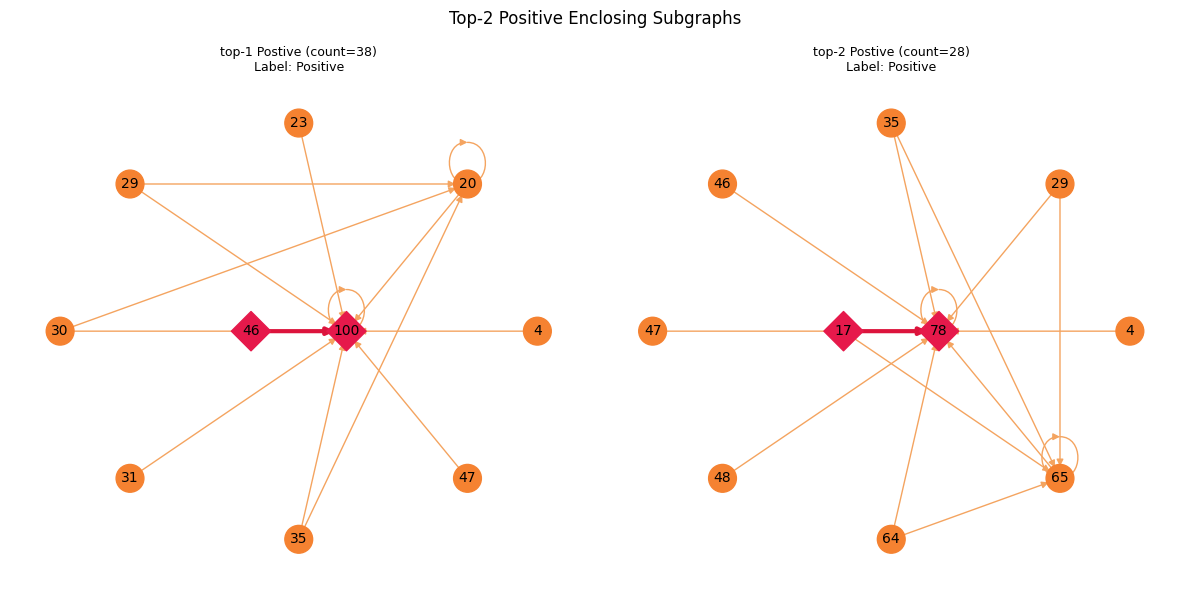

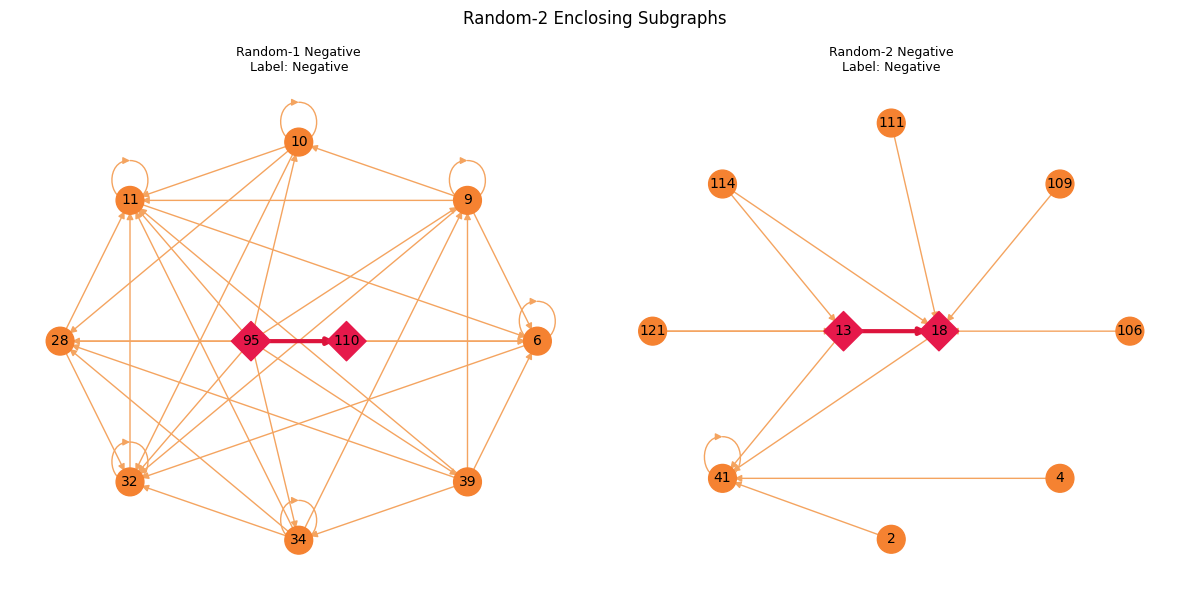

Processing folder: ../../src/matlab/data/result_building_blocks/building_blocks/AEW02_tax_mass


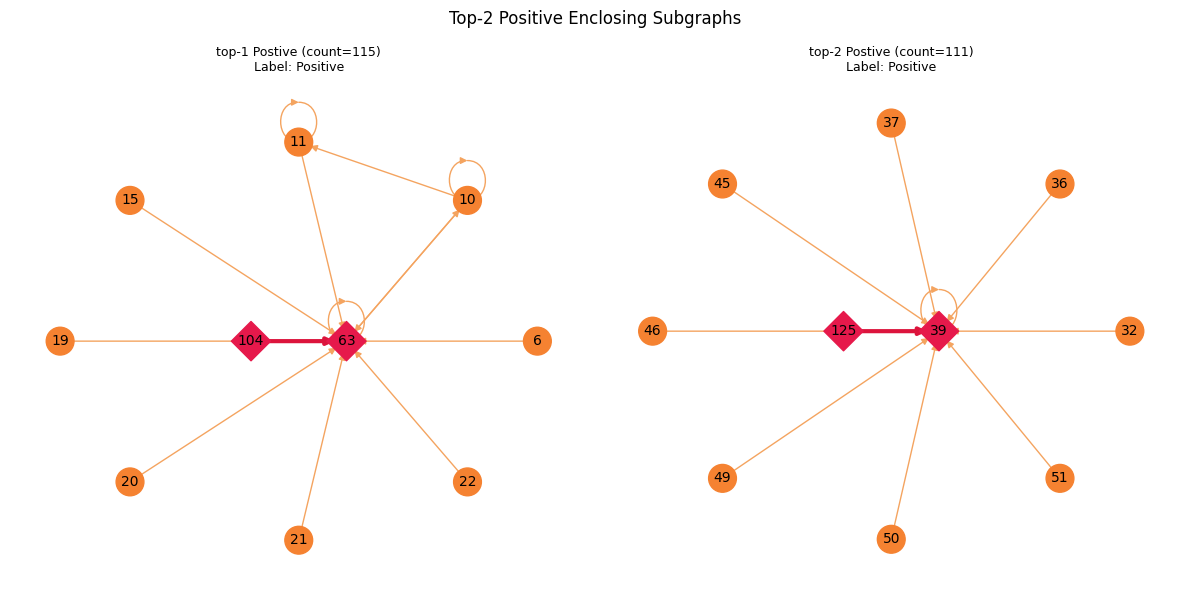

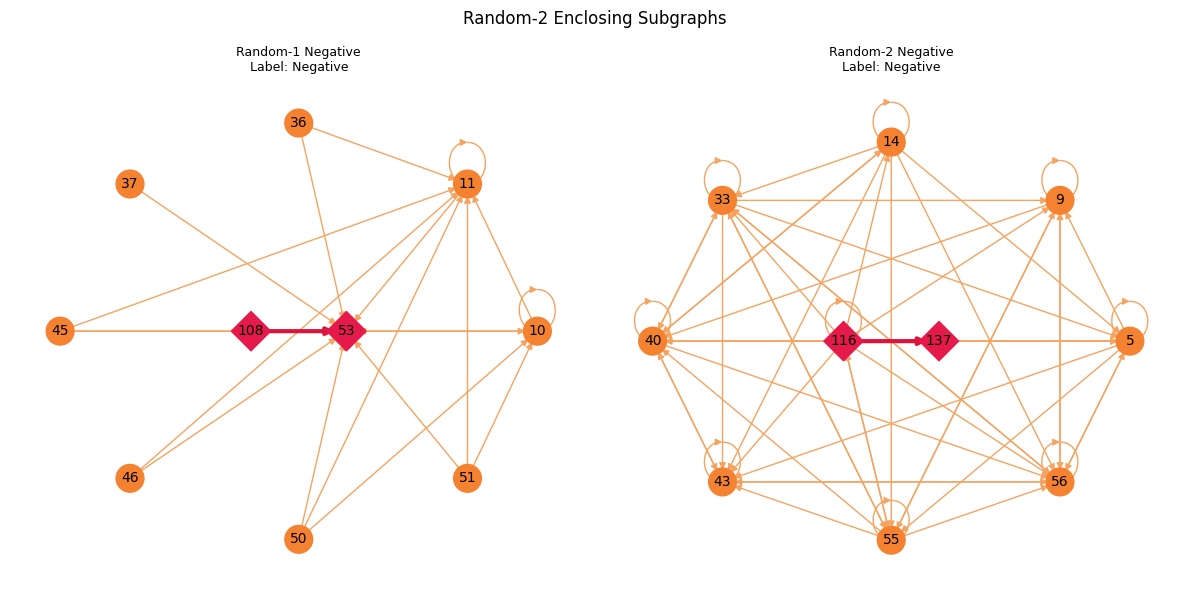

Processing folder: ../../src/matlab/data/result_building_blocks/building_blocks/AEW03_tax_mass


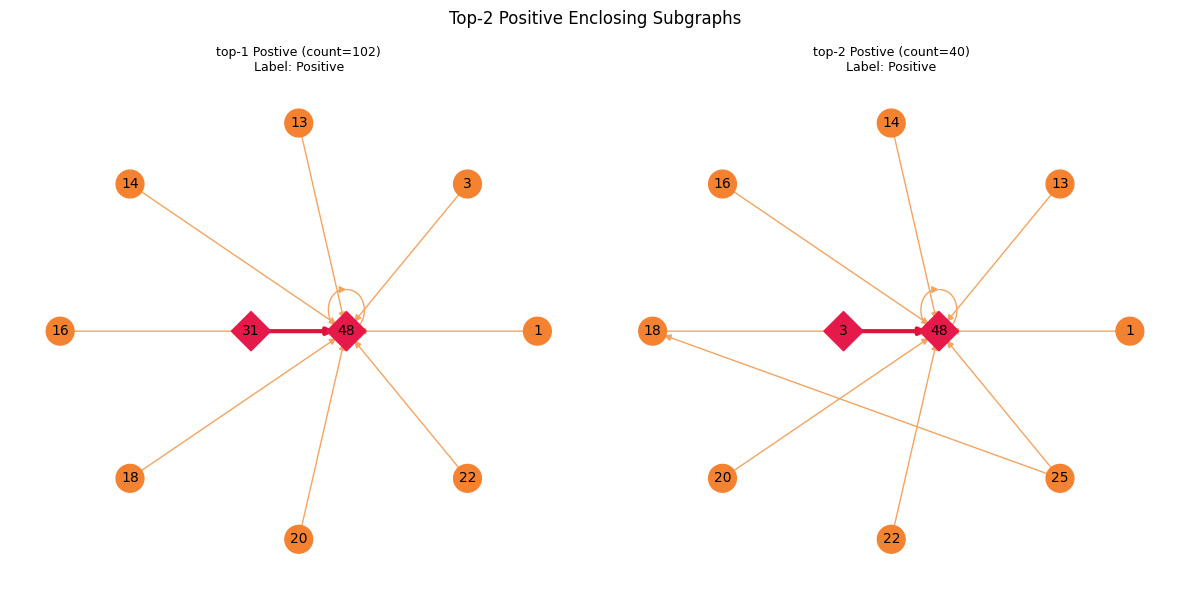

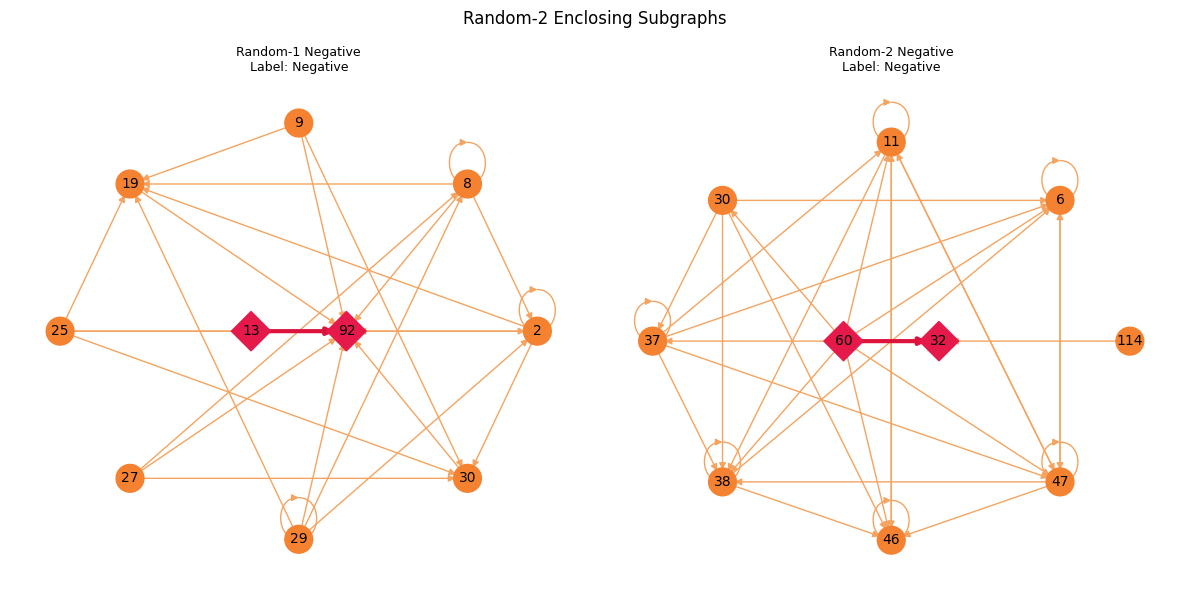

Processing folder: ../../src/matlab/data/result_building_blocks/building_blocks/AEW04_tax_mass


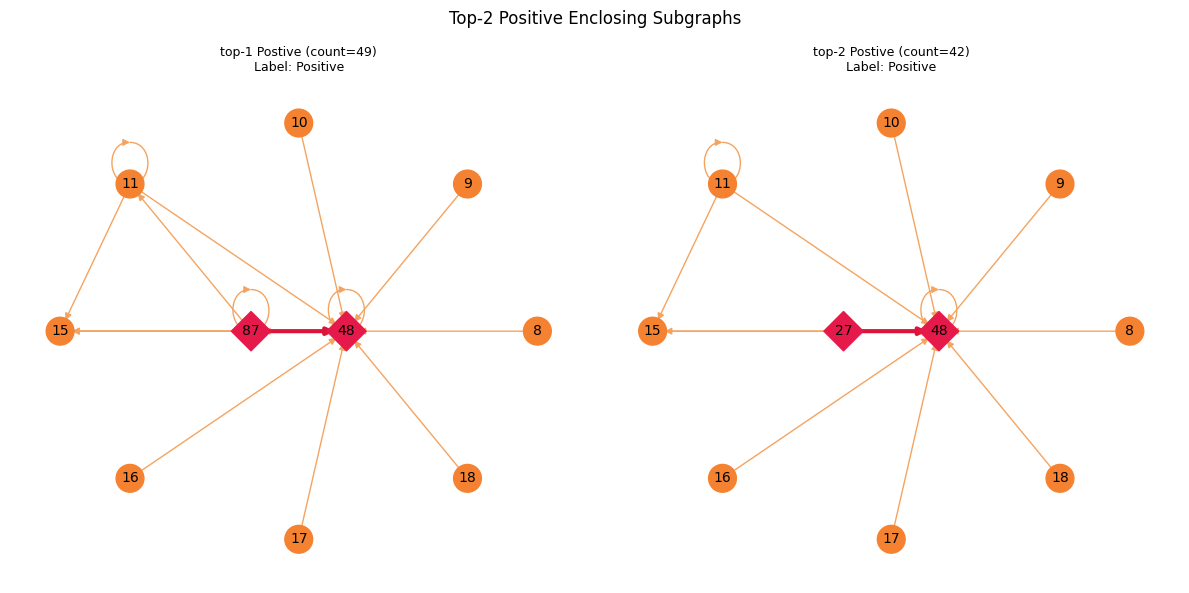

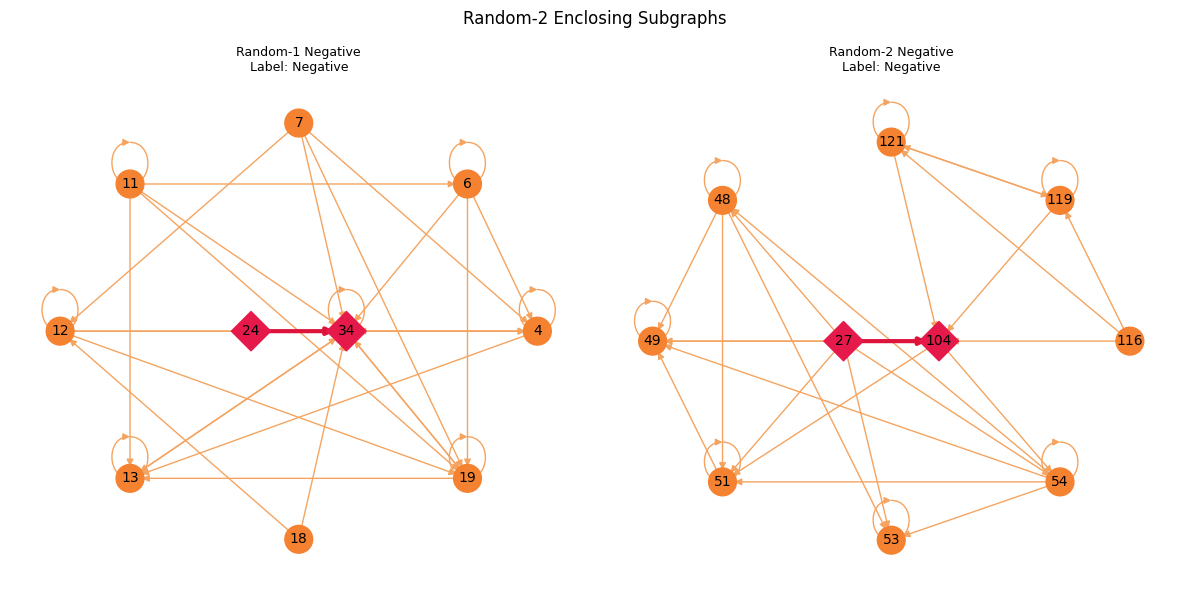

In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.sparse import issparse
from collections import Counter
from math import pi, cos, sin
from networkx.algorithms.isomorphism import DiGraphMatcher

def canonical_hash(adj_matrix):
    G = nx.DiGraph(adj_matrix)
    return nx.weisfeiler_lehman_graph_hash(G, node_attr=None, edge_attr=None)

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

def centered_layout(G, link, radius=2.5):
    source, target = link
    pos = {
        source: np.array([-0.5, 0.0]),
        target: np.array([0.5, 0.0])
    }
    remaining = [n for n in G.nodes() if n not in link]
    n = len(remaining)
    if n == 0:
        return pos
    angles = np.linspace(0, 2 * pi, n, endpoint=False)
    for i, node in enumerate(remaining):
        pos[node] = np.array([radius * cos(angles[i]), radius * sin(angles[i])])
    return pos

def draw_graph_on_ax(adj, nodes, link, label, title, ax):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if adj[i, j] != 0:
                G.add_edge(u, v)
    pos = centered_layout(G, link)
    highlighted_nodes = {link[0], link[1]}
    node_color = ['#e6194b' if n in highlighted_nodes else '#f58231' for n in G.nodes()]
    node_shapes = ['D' if n in highlighted_nodes else 'o' for n in G.nodes()]

    for shape in set(node_shapes):
        nodelist = [n for n, s in zip(G.nodes(), node_shapes) if s == shape]
        colorlist = [node_color[list(G.nodes()).index(n)] for n in nodelist]
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=colorlist, node_shape=shape, node_size=400, ax=ax)
    
    normal_edges = [e for e in G.edges() if e != link]
    nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color='sandybrown', arrows=True, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=[link], edge_color='crimson', width=3, arrows=True, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

    ax.set_title(f"{title}\nLabel: {'Positive' if label == 1 else 'Negative'}", fontsize=9)
    ax.axis('off')

def plot_graphs(subgraphs, titles, suptitle):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for i, (adj, nodes, link, label) in enumerate(subgraphs):
        draw_graph_on_ax(adj, nodes, link, label, titles[i], axes[i])
    plt.suptitle(suptitle, fontsize=12)
    plt.tight_layout()
    plt.show()

root_path = "../../src/matlab/data/result_building_blocks/building_blocks"

for i, folder in enumerate(sorted(os.listdir(root_path))):
    if i >= 5:
        break

    folder_path = os.path.join(root_path, folder)
    if not os.path.isdir(folder_path):
        continue

    print(f"Processing folder: {folder_path}")
    math_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mat")]

    positive_counter = Counter()
    positive_subgraphs = {}
    negative_subgraphs = []

    for path in math_paths:
        try:
            mat = scipy.io.loadmat(path)
        except:
            continue

        if 'ordered_adj' not in mat or 'label' not in mat or 'link' not in mat or 'nodes' not in mat:
            continue

        ordered_adj = sanitize_matrix(mat['ordered_adj'])
        adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
        nodes = [int(x) for x in mat['nodes'].flatten()]
        label = int(mat['label'][0][0])
        link = tuple(int(x) for x in mat['link'].flatten())

        if link[0] not in nodes or link[1] not in nodes:
            continue

        hash_key = canonical_hash(ordered_adj)

        if label == 1:
            positive_counter[hash_key] += 1
            if hash_key not in positive_subgraphs:
                positive_subgraphs[hash_key] = (adj_before, nodes, link, label)
        else:
            negative_subgraphs.append((adj_before, nodes, link, label))

    if not positive_counter:
        print(f"No positive subgraphs found in folder: {folder_path}")
        continue

    # Top 2 postive subgraphs
    most_common_positives = positive_counter.most_common(2)
    positive_to_plot = []
    positive_titles = []

    for i, (hash_key, count) in enumerate(most_common_positives, 1):
        data = positive_subgraphs[hash_key]
        positive_to_plot.append(data)
        positive_titles.append(f"top-{i} Postive (count={count})")

    # 2 random negative subgraphs
    random_negatives = random.sample(negative_subgraphs, min(2, len(negative_subgraphs)))
    negative_titles = [f"Random-{i+1} Negative" for i in range(len(random_negatives))]

    # Plot figures
    plot_graphs(positive_to_plot, positive_titles, "Top-2 Positive Enclosing Subgraphs")
    plot_graphs(random_negatives, negative_titles, "Random-2 Enclosing Subgraphs")

### Motif

In the context of e**cological networks**, a **motif** is a small, recurring pattern of interactions among species - typically involving 2 to 5 nodes - that appers more often than expected by chance.

**In Food Webs:**

- Nodes represent **species**.
- Edges represent **trophic interactions** (who eats whom).
- Motifs reveal **basic building blocks of ecological structure**, such as:
    - Chains (A eats B eats C)
    - Loops (A eats B, B eats C, C eats A)
    - Apparent competition (A and B are both prayed upon by C)
    - Exploitative competition (A and B both prey on C)

Motifs are important because they reflect **core ecological mechanisms** like competirion, predations, and facilitation.

### What does Motifs look like?

Some classic **3- node motif** types (often cited in [Milo et al. 2002](https://doi.org/10.1126/science.298.5594.824) and [Stouffer et al. 2007](https://doi.org/10.1098/rspb.2007.0571)):

| Motif                        | Description         | Sketch                                     |
| ---------------------------- | ------------------- | ------------------------------------------ |
| **Chain**                    | A → B → C           | `A → B → C`                                |
| **Apparent competition**     | A ← C → B           | `A ← C → B`                                |
| **Tri-trophic chain**        | A → B → C           | Same as chain                              |
| **Exploitative competition** | A → C ← B           | `A → C ← B`                                |
| **Omnivory**                 | A → B, A → C, B → C | A consumes both B and C; B also consumes C |
| **Reciprocal predation**     | A ⇄ B               | Mutual feeding                             |
| **No interaction**           | A  B  C             | No edges                                   |

These motifs are usually found by:
    - **Enumerating all size-k subgraphs** in the network.
    - Grouping isomorphic ones together.
    - Counting their frecuency.
    - Comparing to random null models.

## Visualizing the Canonical Form of the Top-1 Positive Building Block

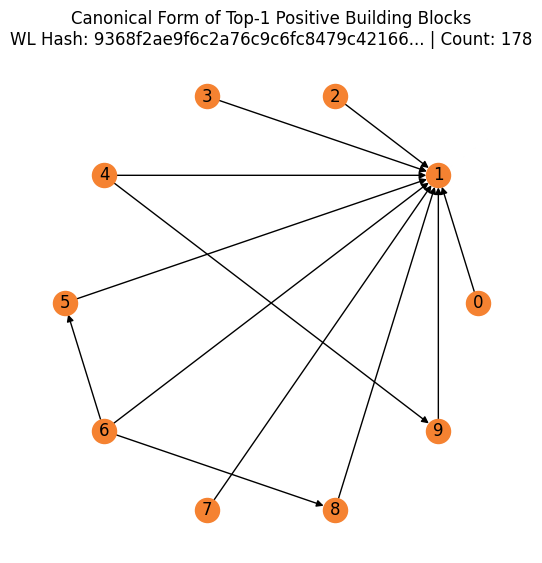

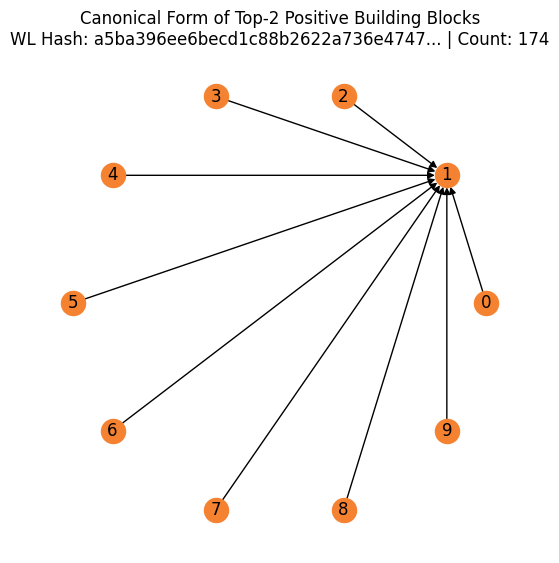

In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import issparse
from collections import Counter

def canonical_hash(adj_matrix):
    G = nx.DiGraph(adj_matrix)
    return nx.weisfeiler_lehman_graph_hash(G, node_attr=None, edge_attr=None)

def visualize_canonical_subgraph(adj_matrix, wl_hash=None, count=None, title="Canonical Form"):
    G = nx.DiGraph(adj_matrix)
    G_canon = nx.convert_node_labels_to_integers(G, ordering='sorted')
    pos = nx.circular_layout(G_canon)
    plt.figure(figsize=(5, 5))
    nx.draw(G_canon, pos, with_labels=True, node_color="#f58231", arrows=True)

    full_title = title
    if count is not None:
        # full_title += f"\nWL Hash: {wl_hash[:10]}... | Count: {count}"
        full_title += f"\nWL Hash: {wl_hash}... | Count: {count}"
    plt.title(full_title)
    plt.axis('off')
    plt.show()

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

folder_path = "../../src/matlab/data/result_building_blocks/building_blocks/Grand Caricaie  marsh dominated by Cladietum marisci, mown  Clmown1_tax_mass"
math_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mat")]

positive_counter = Counter()
positive_subgraphs = {}
negative_subgraphs = []

for path in math_paths:
    mat = scipy.io.loadmat(path)
    if 'ordered_adj' not in mat or 'label' not in mat or 'link' not in mat or 'nodes' not in mat:
        continue

    ordered_adj = sanitize_matrix(mat['ordered_adj'])
    adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
    nodes = [int(x) for x in mat['nodes'].flatten()]
    label = int(mat['label'][0][0])
    link = tuple(int(x) for x in mat['link'].flatten())

    if link[0] not in nodes or link[1] not in nodes:
        continue

    hash_key = canonical_hash(ordered_adj)

    if label == 1:
        positive_counter[hash_key] += 1
        if hash_key not in positive_subgraphs:
            positive_subgraphs[hash_key] = (adj_before, nodes, link, label)
    else:
        negative_subgraphs.append((adj_before, nodes, link, label))

# Top 2 postive subgraphs
most_common_positives = positive_counter.most_common(2)
positive_to_plot = []
positive_titles = []

for i, (hash_key, count) in enumerate(most_common_positives[:2], 1):
    adj, nodes, link, label = positive_subgraphs[hash_key]
    visualize_canonical_subgraph(adj, wl_hash=hash_key, count=count, title=f"Canonical Form of Top-{i} Positive Building Blocks")

### How does WL Graph Hash Method works?

This function applies the **WL graph hashing algorithm** to capture the structure of the graph in a permutation-invariant way:

**- Input:** A networkx.Graph or DiGraph (in my case, converted from ordered_adj)

**- Process:**

    - Starts by assigning initial labels to each node.
    - Iteratively updates each node's label based on a multiset of it's neighbors' label.
    - Sort nad hashes these labels into a final **deterministic string**.

**- Output:** A **string hash** that is:

    - Invariant to node labeling.
    - Different for non-isomorphic graphs.
    - Identical for isomorphic graphs.

Processing folder: ../../src/matlab/data/result_building_blocks/building_blocks/AEW01_tax_mass


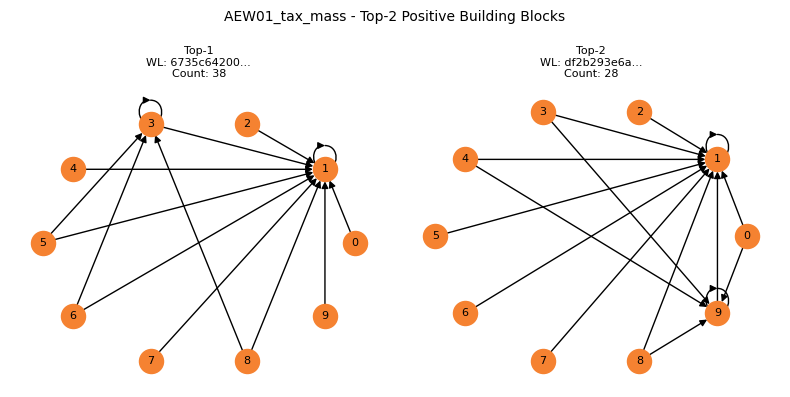

Processing folder: ../../src/matlab/data/result_building_blocks/building_blocks/AEW02_tax_mass


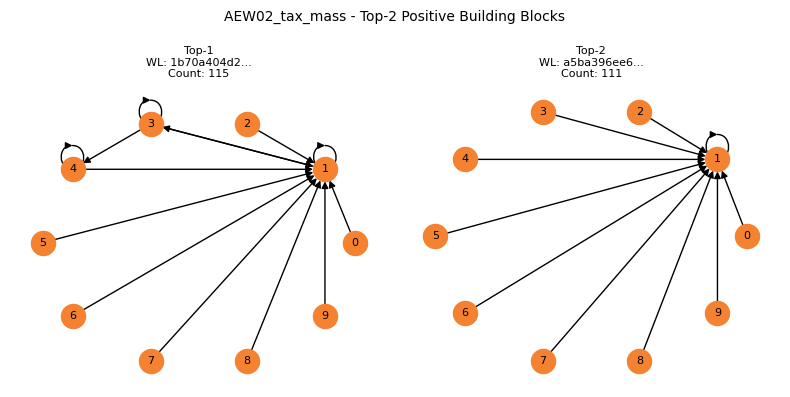

Processing folder: ../../src/matlab/data/result_building_blocks/building_blocks/AEW03_tax_mass


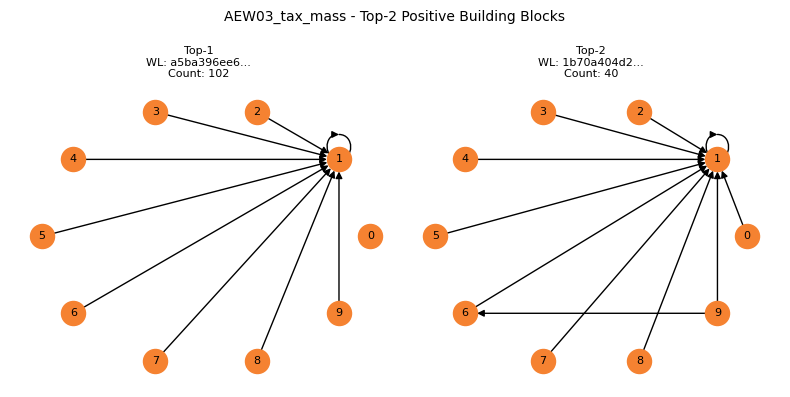

Processing folder: ../../src/matlab/data/result_building_blocks/building_blocks/AEW04_tax_mass


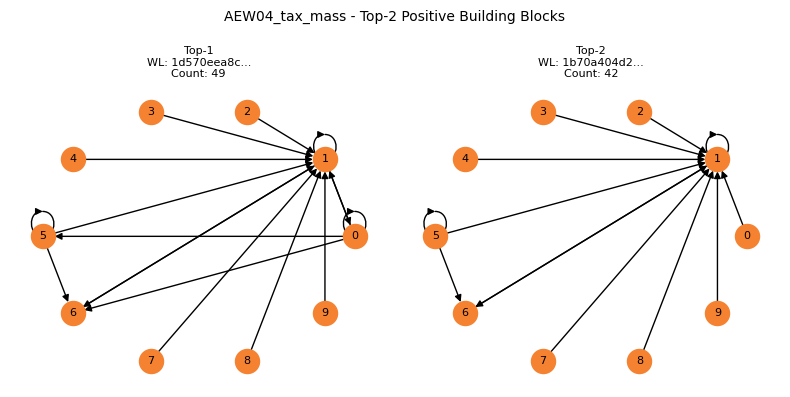

In [3]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import issparse
from collections import Counter

def canonical_hash(adj_matrix):
    G = nx.DiGraph(adj_matrix)
    return nx.weisfeiler_lehman_graph_hash(G, node_attr=None, edge_attr=None)

def visualize_canonical_subgraph(foodweb_name, most_common_positives, positive_subgraphs):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f"{foodweb_name} - Top-2 Positive Building Blocks", fontsize=10)

    for i, (hash_key, count) in enumerate(most_common_positives):
        adj, nodes, link, label = positive_subgraphs[hash_key]
        G = nx.DiGraph(adj)
        G_canon = nx.convert_node_labels_to_integers(G, ordering='sorted')
        pos = nx.circular_layout(G_canon)
        ax = axes[i]
        nx.draw(G_canon, pos, with_labels=True, node_color="#f58231", arrows=True, ax=ax, font_size=8)
        ax.set_title(f"Top-{i+1}\nWL: {hash_key[:10]}...\nCount: {count}", fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

root_path = "../../src/matlab/data/result_building_blocks/building_blocks/"

for i, folder in enumerate(sorted(os.listdir(root_path))):
    if i >= 5:
        break

    folder_path = os.path.join(root_path, folder)
    if not os.path.isdir(folder_path):
        continue

    print(f"Processing folder: {folder_path}")
    math_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mat")]

    positive_counter = Counter()
    positive_subgraphs = {}
    negative_subgraphs = []

    for path in math_paths:
        try:
            mat = scipy.io.loadmat(path)
        except:
            continue

        if 'ordered_adj' not in mat or 'label' not in mat or 'link' not in mat or 'nodes' not in mat:
            continue

        ordered_adj = sanitize_matrix(mat['ordered_adj'])
        adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
        nodes = [int(x) for x in mat['nodes'].flatten()]
        label = int(mat['label'][0][0])
        link = tuple(int(x) for x in mat['link'].flatten())

        if link[0] not in nodes or link[1] not in nodes:
            continue

        hash_key = canonical_hash(ordered_adj)

        if label == 1:
            positive_counter[hash_key] += 1
            if hash_key not in positive_subgraphs:
                positive_subgraphs[hash_key] = (adj_before, nodes, link, label)
        else:
            negative_subgraphs.append((adj_before, nodes, link, label))

    if not positive_counter:
        print(f"No positive subgraphs found in folder: {folder_path}")
        continue

    # Top 2 postive subgraphs
    most_common_positives = positive_counter.most_common(2)
    visualize_canonical_subgraph(folder, most_common_positives, positive_subgraphs)

Processing Food Webs Folders: 100%|██████████| 288/288 [02:23<00:00,  2.00it/s]


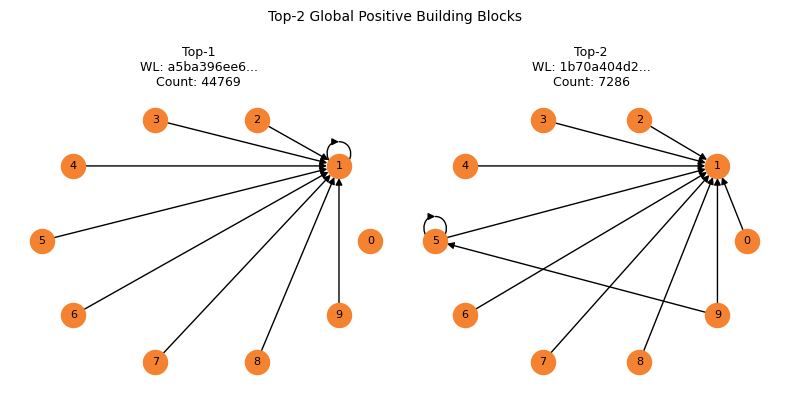

In [5]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import issparse
from collections import Counter
from tqdm import tqdm

global_positive_counter = Counter()
global_positive_subgraphs = {}

def canonical_hash(adj_matrix):
    G = nx.DiGraph(adj_matrix)
    return nx.weisfeiler_lehman_graph_hash(G, node_attr=None, edge_attr=None)

def sanitize_matrix(mat):
    if issparse(mat):
        return mat.toarray().astype(float)
    elif isinstance(mat, np.ndarray) and mat.dtype == object:
        try:
            return np.array([[float(cell) for cell in row] for row in mat], dtype=float)
        except Exception:
            return np.array(mat.tolist(), dtype=float)
    else:
        return np.array(mat, dtype=float)

def plot_global_top_motifs(global_top, global_positive):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle("Top-2 Global Positive Building Blocks", fontsize=10)

    for i, (wl_hash, count) in enumerate(global_top):
        adj, nodes, link, label = global_positive_subgraphs[wl_hash]
        G = nx.DiGraph(adj)
        G_canon = nx.convert_node_labels_to_integers(G, ordering='sorted')
        pos = nx.circular_layout(G_canon)
        ax = axes[i]
        nx.draw(G_canon, pos, with_labels=True, node_color="#f58231", arrows=True, ax=ax, font_size=8)
        ax.set_title(f"Top-{i+1}\nWL: {wl_hash[:10]}...\nCount: {count}", fontsize=9)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

root_path = "../../src/matlab/data/result_building_blocks/building_blocks/"
folders = sorted([f for f in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, f))])

for folder in tqdm(folders, desc="Processing Food Webs Folders"):
    folder_path = os.path.join(root_path, folder)
    if not os.path.isdir(folder_path):
        continue

    math_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".mat")]

    for path in math_paths:
        try:
            mat = scipy.io.loadmat(path)
        except:
            continue
    
        if 'ordered_adj' not in mat or 'label' not in mat or 'link' not in mat or 'nodes' not in mat:
            continue

        ordered_adj = sanitize_matrix(mat['ordered_adj'])
        adj_before = sanitize_matrix(mat.get('adj_before', mat.get('adj')))
        nodes = [int(x) for x in mat['nodes'].flatten()]
        label = int(mat['label'][0][0])
        link = tuple(int (x) for x in mat['link'].flatten())

        if link[0] not in nodes or link[1] not in nodes:
            continue

        hash_key = canonical_hash(ordered_adj)
        
        if label == 1:
            global_positive_counter[hash_key] += 1
            if hash_key not in global_positive_subgraphs:
                global_positive_subgraphs[hash_key] = (adj_before, nodes, link, label)

# Top 2 global positive subgraphs
global_top = global_positive_counter.most_common(2)
plot_global_top_motifs(global_top, global_positive_subgraphs)

### **Implementation of feedforward loop motif detection and visualization**

The **Feedforward Loop (FFL)** is a specific **3-node directed motif** where:

* Node A → Node B
* Node A → Node C
* Node B → Node C

I can:

* **Scan original directed adjacency matrix** for all size-3 node combinations.
* Check if their induced subgraph matches the FFL pattern.
* Count how often this motif appears, and
* Visualize those that match (e.g. with `networkx.DiGraph`, layout with fixed A-B-C positioning).

There are packages to assist, like:

* [`networkx.algorithms.isomorphism.DiGraphMatcher`](https://networkx.org/documentation/stable/reference/algorithms/isomorphism.html)
* [`mfinder`](https://www.weizmann.ac.il/mcb/UriAlon/download/network-motif-software) (original software by Milo et al., can be wrapped or reimplemented)
* [`graph-tool`](https://graph-tool.skewed.de/) (fast C++-backed motif search)

**Milo et al.’s motif detection is applied to the *entire network*.**
They:

* Enumerate **all possible subgraphs of size N (e.g. N=3)** in the network.
* Count the frequency of each **isomorphic type** (e.g. FFL, cascade, etc.).
* Compare against **randomized versions of the network** (same degree seq) to see which motifs are overrepresented — those are called **motifs**.

In essence:

* WLNM subgraphs are **contextual neighborhoods**.
* Milo motifs are **global micro-patterns**.

## **Following Steps**

#### Step 1: Motif Detection in Full Network

* Implement size-3 directed subgraph enumeration (e.g. with `networkx` or `mfinder`)
* Identify FFLs (can build an `FFL_adjacency = [[0,1,1],[0,0,1],[0,0,0]]` and compare with induced subgraphs via isomorphism).

#### Step 2: Visualize detected FFLs

* Plot with `nx.DiGraph`, layout as triangle (A-B-C), color edges A→C in distinct color.

#### Step 3: Compare with Building Blocks

* Count how often a positive WLNM subgraph matches the FFL motif (via isomorphism with canonical ordered\_adj).
* Optionally annotate `.mat` files with motif type (e.g. “FFL” or “cascade”).

#### Step 4: Statistical Overrepresentation

* Shuffle the full adjacency matrix preserving in/out degree.
* Count motif frequency in random networks.
* Compute Z-score:

  $$
  Z = \frac{f_\text{real} - \mu_\text{random}}{\sigma_\text{random}}
  $$